In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Download Tesla stock data
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2022-01-01'
tesla_data = yf.download(ticker, start=start_date, end=end_date)

tesla_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500
...,...,...,...,...,...,...
2021-12-27,357.890015,372.333344,356.906677,364.646667,364.646667,71145900
2021-12-28,369.829987,373.000000,359.473328,362.823334,362.823334,60324000
2021-12-29,366.213318,368.000000,354.713318,362.063324,362.063324,56154000


In [2]:
tesla_data.reset_index(inplace=True)

In [3]:
tesla_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500
...,...,...,...,...,...,...,...
1758,2021-12-27,357.890015,372.333344,356.906677,364.646667,364.646667,71145900
1759,2021-12-28,369.829987,373.000000,359.473328,362.823334,362.823334,60324000
1760,2021-12-29,366.213318,368.000000,354.713318,362.063324,362.063324,56154000
1761,2021-12-30,353.776672,365.183319,351.049988,356.779999,356.779999,47040900


In [4]:
tesla_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Data Preprocessing
tesla_data = tesla_data[['Date','Close']]
tesla_data

,Date,Close
0,2015-01-02,14.620667
1,2015-01-05,14.006000
2,2015-01-06,14.085333
3,2015-01-07,14.063333
4,2015-01-08,14.041333
...,...,...
1758,2021-12-27,364.646667
1759,2021-12-28,362.823334
1760,2021-12-29,362.063324
1761,2021-12-30,356.779999


In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tesla_data['Close'])
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : 0.837300140204809
P Value : 0.9922150167814809



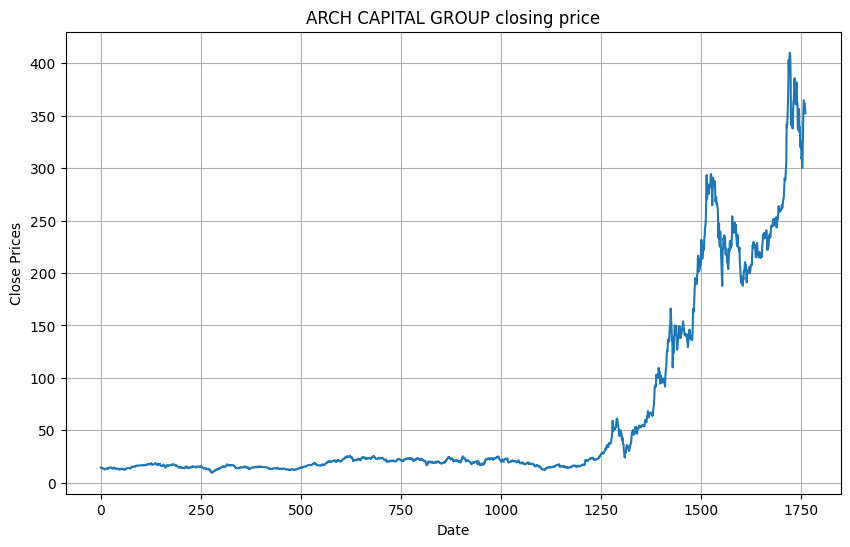

In [7]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(tesla_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()


<Axes: ylabel='Density'>

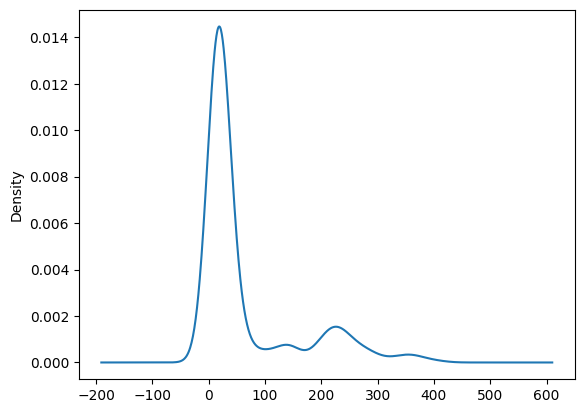

In [8]:
tesla_data['Close'].plot(kind='kde')

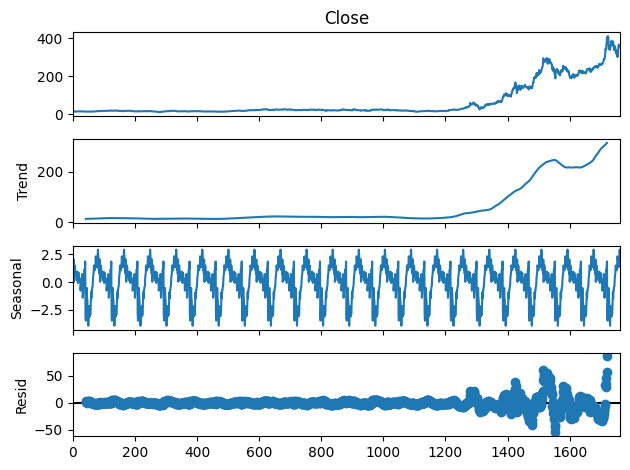

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tesla_data['Close'], model='additive', period=7*4*3)
fig = decomposition.plot()
plt.show()

In [10]:
def test_stationarity(data):
    # Perform Dickey-Fuller test
    result = adfuller(data, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print('Data is stationary')
    else:
        print('Data is non-stationary')

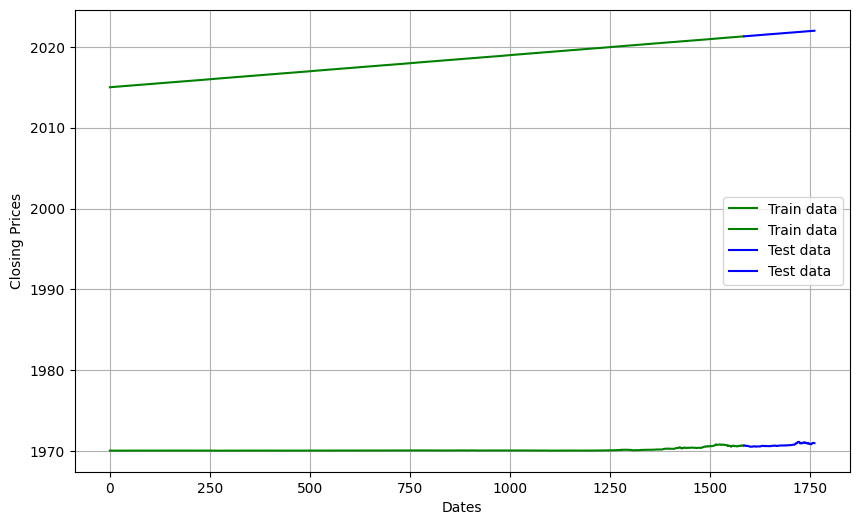

In [11]:
train_data, test_data = tesla_data[:int(len(tesla_data)*0.9)], tesla_data[int(len(tesla_data)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
train_data

,Date,Close
0,2015-01-02,14.620667
1,2015-01-05,14.006000
2,2015-01-06,14.085333
3,2015-01-07,14.063333
4,2015-01-08,14.041333
...,...,...
1581,2021-04-15,246.283340
1582,2021-04-16,246.593338
1583,2021-04-19,238.210007
1584,2021-04-20,239.663330


In [13]:
test_data

,Date,Close
1586,2021-04-22,239.896667
1587,2021-04-23,243.133331
1588,2021-04-26,246.066666
1589,2021-04-27,234.913330
1590,2021-04-28,231.466660
...,...,...
1758,2021-12-27,364.646667
1759,2021-12-28,362.823334
1760,2021-12-29,362.063324
1761,2021-12-30,356.779999


In [14]:
print(train_data.shape)
print(test_data.shape)

(1586, 2)
(177, 2)


In [15]:
differenced_data = train_data['Close'].diff().dropna()
test_stationarity(differenced_data)

ADF Statistic: -6.33725086690286
p-value: 2.8108542409360035e-08
Data is stationary


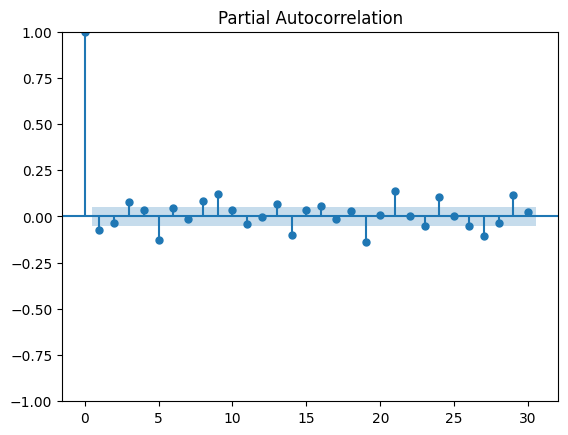

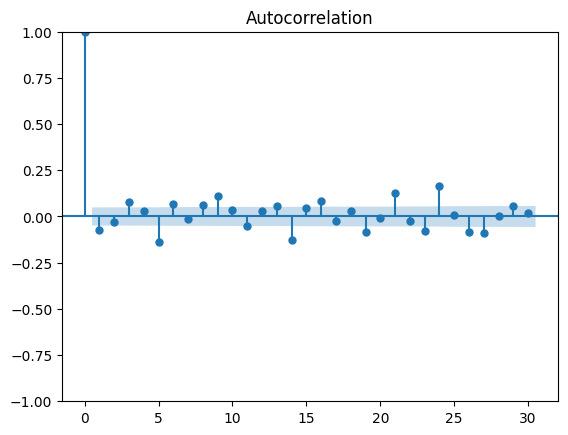

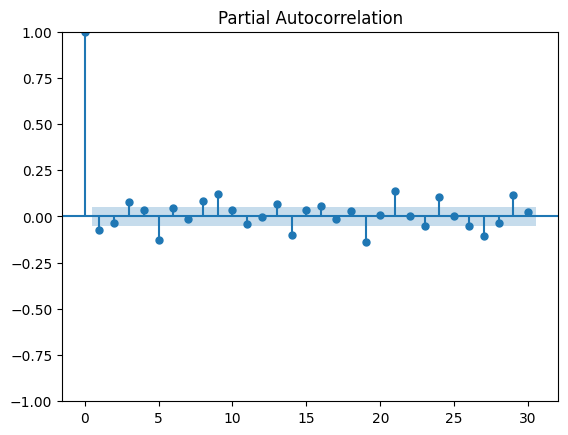

In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(differenced_data, lags=30)
plot_pacf(differenced_data, lags=30)

In [39]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
p = q = range(0, 6)
d = 1
pdq = list(itertools.product(p, [d], q))

results = []
models = []
for param in pdq:
    _model = ARIMA(train_data['Close'], order=param)
    try:
        results.append(_model.fit().aic)
        models.append('ARIMA (' + ' '.join(list(map(str, param)))+')')
    except:
        pass

all_model = pd.DataFrame(list(zip(models, results)), columns=['model', 'AIC'])
all_model.sort_values(by='AIC').reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

,model,AIC
0,ARIMA (4 1 4),8044.602312
1,ARIMA (3 1 3),8047.533634
2,ARIMA (3 1 2),8051.147728
3,ARIMA (4 1 5),8054.250621
4,ARIMA (5 1 4),8057.163556
5,ARIMA (5 1 5),8058.935737
6,ARIMA (3 1 4),8072.673165
7,ARIMA (4 1 2),8075.159389
8,ARIMA (2 1 3),8080.966775
9,ARIMA (1 1 5),8086.489282


In [17]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00


In [18]:
training_data_1 = train_data['Close'].values
test_data_1 = test_data['Close'].values

In [20]:
print(len(test_data_1))

177


In [21]:
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in training_data_1]
model_predictions = []
N_test_observations = len(test_data_1)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,4),enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data_1[time_point]
    history.append(true_test_value)
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [22]:
len(model_predictions)

177

In [26]:
# report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test_data_1, model_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_1,model_predictions )
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_1, model_predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(model_predictions - test_data_1)/np.abs(test_data_1))
print('MAPE: '+str(mape))

MSE: 87.11196474199856
MAE: 6.161546238229842
RMSE: 9.333379063447415
MAPE: 0.02199130225841882


In [27]:
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in training_data_1]
model_predictions_1 = []
N_test_observations = len(test_data_1)
for time_point in range(N_test_observations):
    model_1 = ARIMA(history, order=(1,1,1),enforce_stationarity=False)
    model_fit_1 = model_1.fit()
    output_1 = model_fit_1.forecast()
    yhat_1 = output_1[0]
    model_predictions_1.append(yhat_1)
    true_test_value = test_data_1[time_point]
    history.append(true_test_value)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
mse = mean_squared_error(test_data_1, model_predictions_1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_1,model_predictions_1 )
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_1, model_predictions_1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(model_predictions_1 - test_data_1)/np.abs(test_data_1))
print('MAPE: '+str(mape))

MSE: 82.38298608681195
MAE: 6.024437560047721
RMSE: 9.07650737270741
MAPE: 0.02148918404077061


In [29]:
len(model_predictions_1)

177

In [46]:
tesla_data.index

RangeIndex(start=0, stop=1763, step=1)

<ipython-input-42-22090f5d09c4>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(tesla_data['Date'],tesla_data['Close'], 'green', color='blue', label='Training Data')


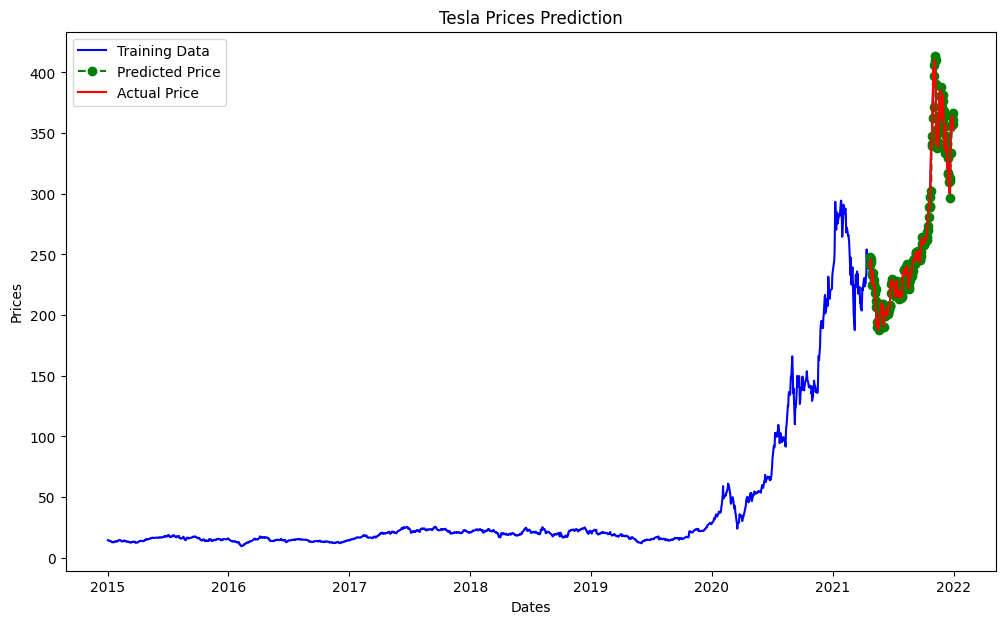

In [42]:
plt.figure(figsize=(12,7))
plt.plot(tesla_data['Date'],tesla_data['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data['Date'], model_predictions, color='green', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data['Date'], test_data['Close'], color='red', label='Actual Price')
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
# plt.xticks(np.arange(0,1857, 300), tesla_data['Date'][0:1857:300])
plt.legend()

In [33]:
print(len(test_data))

177


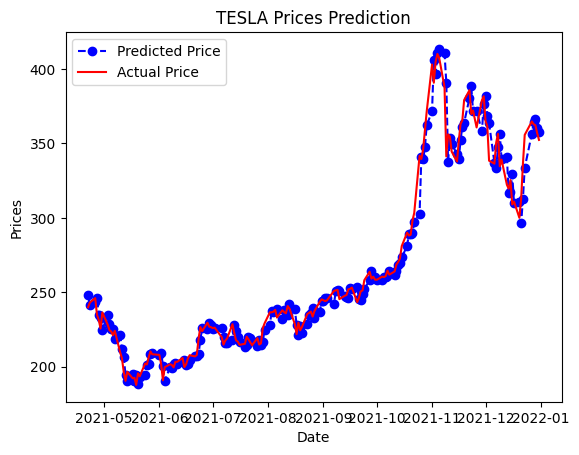

In [47]:
test_set_range = tesla_data[int(len(tesla_data)*0.9):].index
plt.plot(test_data['Date'], model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data['Date'], test_data['Close'], color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), tesla_data.index[881:1259:50])
plt.legend()
plt.show()

LSTM

In [48]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [49]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(tesla_data['Close'].values.reshape(-1, 1))


In [50]:
train_data = scaled_data[ :len(train_data) , 0:1 ]
test_data = scaled_data[ len(train_data)-60: , 0:1 ]

In [51]:
train_data.shape,test_data.shape

((1586, 1), (237, 1))

In [52]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [53]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [54]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [55]:
x_train.shape , y_train.shape

((1526, 60, 1), (1526,))

In [56]:
model =Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))


model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor='loss', patience=10 , restore_best_weights=True)]
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32 , callbacks = callbacks )

Epoch 1/100
48/48 [==============================] - 9s 82ms/step - loss: 0.0036 - mean_absolute_error: 0.0301
Epoch 2/100
48/48 [==============================] - 3s 57ms/step - loss: 3.9754e-04 - mean_absolute_error: 0.0119
Epoch 3/100
48/48 [==============================] - 3s 55ms/step - loss: 4.3051e-04 - mean_absolute_error: 0.0113
Epoch 4/100
48/48 [==============================] - 3s 58ms/step - loss: 3.1654e-04 - mean_absolute_error: 0.0097
Epoch 5/100
48/48 [==============================] - 4s 76ms/step - loss: 2.5648e-04 - mean_absolute_error: 0.0084
Epoch 6/100
48/48 [==============================] - 3s 54ms/step - loss: 2.4538e-04 - mean_absolute_error: 0.0083
Epoch 7/100
48/48 [==============================] - 3s 55ms/step - loss: 3.0532e-04 - mean_absolute_error: 0.0106
Epoch 8/100
48/48 [==============================] - 3s 54ms/step - loss: 2.3784e-04 - mean_absolute_error: 0.0087
Epoch 9/100
48/48 [==============================] - 4s 78ms/step - loss: 2.1032e-04

In [59]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [60]:
x_test.shape , y_test.shape

((177, 60, 1), (177,))

In [61]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

6/6 [==============================] - 1s 16ms/step


(177, 1)

In [62]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

MSE = (np.mean( y_test - predictions )**2).round(2)
print("MSE:",MSE)
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
print("RMSE:",RMSE)
MAPE = np.mean(np.abs(predictions - y_test)/np.abs(y_test))
print("MAPE:",MAPE)


MSE: 4.81
RMSE: 2.19
MAPE: 0.2403938044464392


<ipython-input-63-7bc2fa80a1b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


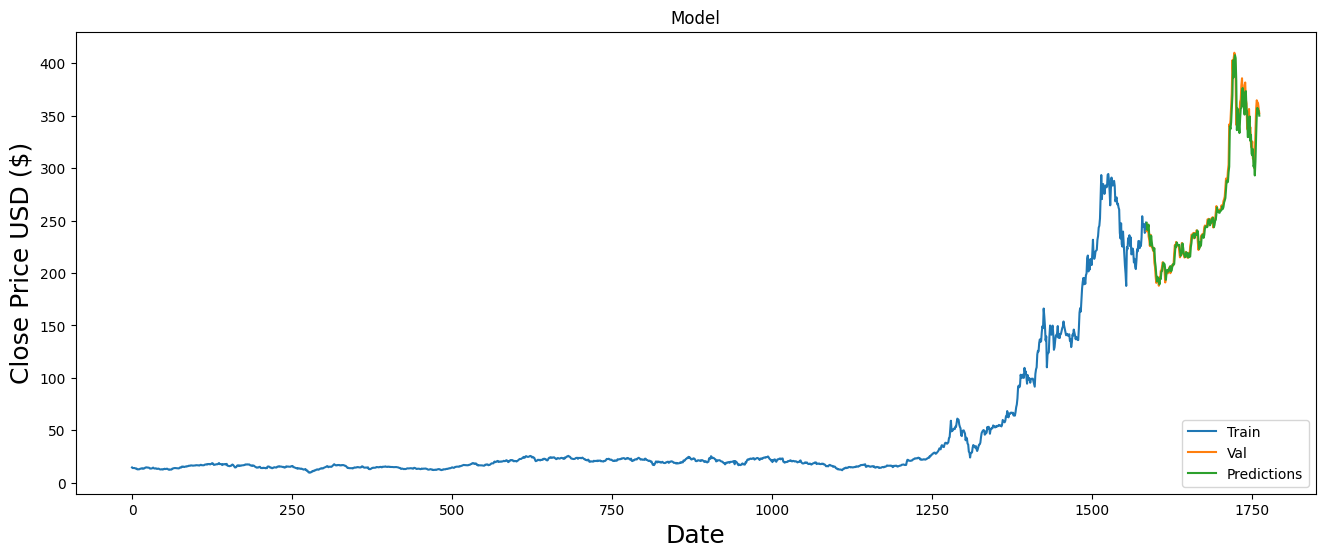

In [63]:
train = tesla_data[:len(train_data)]
valid = tesla_data[len(train_data):]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()